# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import IPython

sns.set_theme() # Setting seaborn as default style

## Import electricity data

### Electricity data from Electricity Maps

In [2]:
# Years of Electricity Map (EM) data that will be imported
years = [2020, 2021]

# Features that will be extracted from the data and their shorter handle
features = {
    "power_production_wind_avg": "prod_wind",
    "power_production_solar_avg": "prod_solar"
}

# Import Electricity Map data
em_list = []

for year in years:
    em_list.append(pd.read_csv(f"..\data\electricity-map\ElectricityMap_DE_{year}.csv", sep=",",
                               parse_dates=["datetime"], index_col=["datetime"]))
em = pd.concat(em_list, axis=0, ignore_index=False, verify_integrity=True)

In [3]:
# Is datetime in UTC? -> Does datetime match with timestamp?
# timestamp1 = data["datetime"].apply(pd.Timestamp.timestamp)
timestamp1 = em.index.to_series().apply(pd.Timestamp.timestamp)
timestamp2 = em["timestamp"].astype(float)

timestamp1.equals(timestamp2)

True

No time correction necessary.

In [4]:
# Extract the relevant data
em = pd.DataFrame(em, columns=features.keys())
# Rename columns
em = em.rename(columns=features)
em.head()

,prod_wind,prod_solar
datetime,,
2020-01-01 00:00:00+00:00,6989.50,0.0
2020-01-01 01:00:00+00:00,7371.25,0.0
2020-01-01 02:00:00+00:00,7447.75,0.0
2020-01-01 03:00:00+00:00,7699.25,0.0
2020-01-01 04:00:00+00:00,7703.00,0.0


### Electricity data from Electricity Charts

In [5]:
# Years of Electricity Charts (EC) data that will be imported
years = [*range(2017, 2021+1)]


# Features that will be extracted from the data and their shorter handle
features = {
    "Wind Offshore": "prod_wind_offshore",
    "Wind Onshore": "prod_wind_onshore",
    "Solar": "prod_solar"
}

# Import Electricity Charts data
ec_list = []

for year in years:
    ec_list.append(pd.read_csv(f"..\data\energy-charts\energy-charts_{year}.csv", sep=",",
                               parse_dates=["Datum (UTC)"], index_col=["Datum (UTC)"]))
ec = pd.concat(ec_list, axis=0, ignore_index=False, verify_integrity=True)

# Extract the relevant data
ec = pd.DataFrame(ec, columns=features.keys())
# Rename columns
ec = ec.rename(columns=features)
# Rename index
ec = ec.reset_index()
ec = ec.rename(columns={"Datum (UTC)": "datetime"})
ec = ec.set_index("datetime")

ec.head()

,prod_wind_offshore,prod_wind_onshore,prod_solar
datetime,,,
2017-01-01 00:00:00+00:00,3300.8,12197.2,0.0
2017-01-01 00:15:00+00:00,3296.9,12173.4,0.0
2017-01-01 00:30:00+00:00,3296.3,12188.3,0.0
2017-01-01 00:45:00+00:00,3293.1,12107.7,0.0
2017-01-01 01:00:00+00:00,3293.8,12113.1,0.0


In [6]:
# Combine offshore and onshore
prod_wind = ec["prod_wind_offshore"] + ec["prod_wind_onshore"]
ec.insert(0, "prod_wind", prod_wind)
ec = ec.drop(["prod_wind_offshore","prod_wind_onshore"], axis=1)
# Remove data not from full hour
ec = ec[ec.index.minute==0]

ec.head()

,prod_wind,prod_solar
datetime,,
2017-01-01 00:00:00+00:00,15498.0,0.0
2017-01-01 01:00:00+00:00,15406.9,0.0
2017-01-01 02:00:00+00:00,14922.3,0.0
2017-01-01 03:00:00+00:00,15022.0,0.0
2017-01-01 04:00:00+00:00,15234.0,0.0


### Comparison of electricity data sources

In [7]:
em.describe()

,prod_wind,prod_solar
count,17544.000000,17544.000000
mean,13886.152388,5268.331823
std,10325.899628,8058.754017
min,135.750000,0.000000
25%,5605.750000,0.000000
50%,11166.250000,168.250000
75%,20123.000000,8548.250000
max,46953.250000,36175.250000


In [8]:
ec.describe()

,prod_wind,prod_solar
count,43824.000000,43824.000000
mean,13137.179680,5297.749265
std,9696.750206,8169.019025
min,78.700000,0.000000
25%,5417.450000,0.000000
50%,10640.500000,84.200000
75%,18721.350000,8524.650000
max,45825.500000,39372.700000


### Choose data source

In [9]:
# Use Electricity Charts data from 2017 to 2021 
df = ec

## Statistics of the data
### Plot data

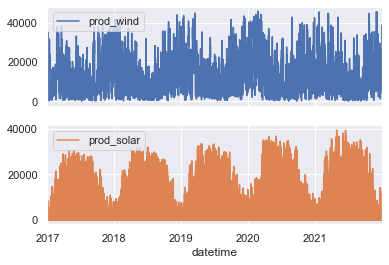

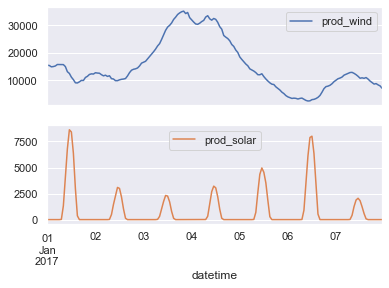

In [10]:
# plot whole year
df.plot(subplots=True)
# plot first 10 days
_ = df[0:7*24].plot(subplots=True)

### Determining the most important frequencies

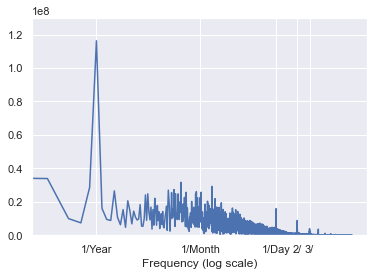

In [11]:
fft = np.fft.rfft(df["prod_wind"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df["prod_wind"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.plot(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 1.3e8)
# plt.xlim(.5, max(plt.xlim()))
plt.xticks([1, 30.44, 365.2524, 365.2524*2, 365.2524*3],
           labels=['1/Year', '1/Month', '1/Day', '2/', '3/'])
_ = plt.xlabel('Frequency (log scale)')

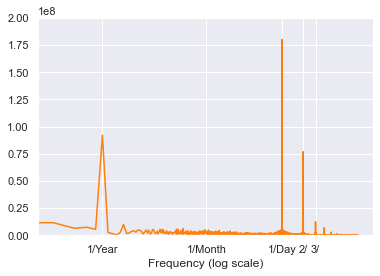

In [12]:
fft = np.fft.rfft(df["prod_solar"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df["prod_solar"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.plot(f_per_year, np.abs(fft), 'tab:orange')
plt.xscale('log')
plt.ylim(0, 2e8)
# plt.xlim([1, max(plt.xlim())])
plt.xticks([1, 30.44, 365.2524, 365.2524*2, 365.2524*3],
           labels=['1/Year', '1/Month', '1/Day', '2/', '3/'])
_ = plt.xlabel('Frequency (log scale)')

## Create periodical time signals

In [13]:
day_s = 24*60*60
year_s = (365.2425)*day_s
# timestamp_s = em["timestamp"]
timestamp_s=df.index.astype('int64') // 10**9

df["day_sin"] = np.sin(timestamp_s * (2 * np.pi / day_s))
df["day_cos"] = np.cos(timestamp_s * (2 * np.pi / day_s))
df["year_sin"] = np.sin(timestamp_s * (2 * np.pi / year_s))
df["year_cos"] = np.cos(timestamp_s * (2 * np.pi / year_s))

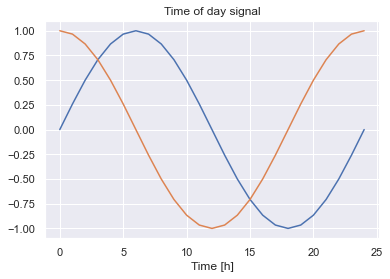

In [14]:
# plotting a day
plt.plot(np.array(df["day_sin"])[:25])
plt.plot(np.array(df["day_cos"])[:25])
plt.xlabel('Time [h]')
_ = plt.title('Time of day signal')

## Create solar elevation from ground
The angle varies with the location. We calculate a single feature for the [center of Germany](https://de.wikipedia.org/wiki/Mittelpunkte_Deutschlands) (♁51° 8′ 0″ N, 10° 25′ 0″ O, determined by the center of gravity of the surface 😉) and the [mean height of Germany](https://de.wikipedia.org/wiki/Liste_der_L%C3%A4nder_nach_durchschnittlicher_H%C3%B6he) (263 m)

In [15]:
import pvlib
from pvlib.location import Location

# create location object
site = Location(51.133, 10.416, altitude=263, tz="UTC", name='COG, Germany')

# estimate the solar position
solpos = site.get_solarposition(df.index)
solpos.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
datetime,,,,,,
2017-01-01 00:00:00+00:00,150.908284,150.908284,-60.908284,-60.908284,18.317213,-3.437913
2017-01-01 01:00:00+00:00,146.058615,146.058615,-56.058615,-56.058615,43.235850,-3.457635
2017-01-01 02:00:00+00:00,138.554986,138.554986,-48.554986,-48.554986,62.309903,-3.477348
2017-01-01 03:00:00+00:00,129.734647,129.734647,-39.734647,-39.734647,77.172490,-3.497051
2017-01-01 04:00:00+00:00,120.400744,120.400744,-30.400744,-30.400744,89.630477,-3.516745


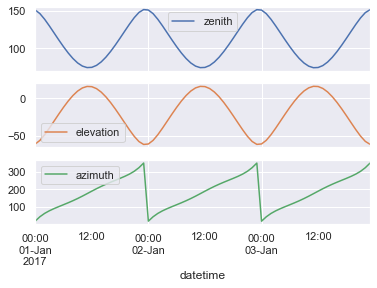

In [16]:
# plot features
_ = solpos.iloc[:72][["zenith", "elevation", "azimuth"]].plot(subplots=True)

In [17]:
# append solar elevation to dataframe
df["solar_el"] = solpos["elevation"]

# clip elevation below zero?
df["solar_el_clip"] = df["solar_el"].clip(lower=0)

In [18]:
df.head()

,prod_wind,prod_solar,day_sin,day_cos,year_sin,year_cos,solar_el,solar_el_clip
datetime,,,,,,,,
2017-01-01 00:00:00+00:00,15498.0,0.0,2.504006e-13,1.000000,0.010364,0.999946,-60.908284,0.0
2017-01-01 01:00:00+00:00,15406.9,0.0,2.588190e-01,0.965926,0.011081,0.999939,-56.058615,0.0
2017-01-01 02:00:00+00:00,14922.3,0.0,5.000000e-01,0.866025,0.011798,0.999930,-48.554986,0.0
2017-01-01 03:00:00+00:00,15022.0,0.0,7.071068e-01,0.707107,0.012515,0.999922,-39.734647,0.0
2017-01-01 04:00:00+00:00,15234.0,0.0,8.660254e-01,0.500000,0.013231,0.999912,-30.400744,0.0


## Preview of data normalization
We can't do this in this notebook yet, since all the data should be normalized over the training set and not the whole set (so the network doen't get an implicit preview of test values during training).

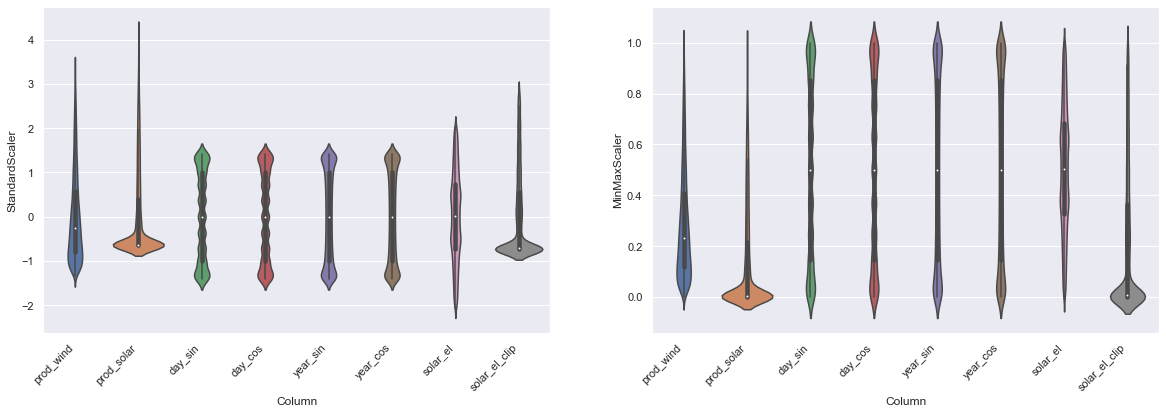

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Standardize dataframe
df_std = pd.DataFrame(StandardScaler().fit_transform(df),
                      columns=df.columns, index=df.index)
# Rescale / min-max normalize dataframe
df_scl = pd.DataFrame(MinMaxScaler().fit_transform(df),
                      columns=df.columns, index=df.index)

# plot normalizations
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)
sns.violinplot(ax=axes[0], x='Column', y='StandardScaler',
               data=df_std.melt(var_name='Column', value_name='StandardScaler'))
sns.violinplot(ax=axes[1], x='Column', y='MinMaxScaler',
               data=df_scl.melt(var_name='Column', value_name='MinMaxScaler'))
axes[0].set_xticklabels(df.keys(), rotation=45, ha="right")
_ = axes[1].set_xticklabels(df.keys(), rotation=45, ha="right")


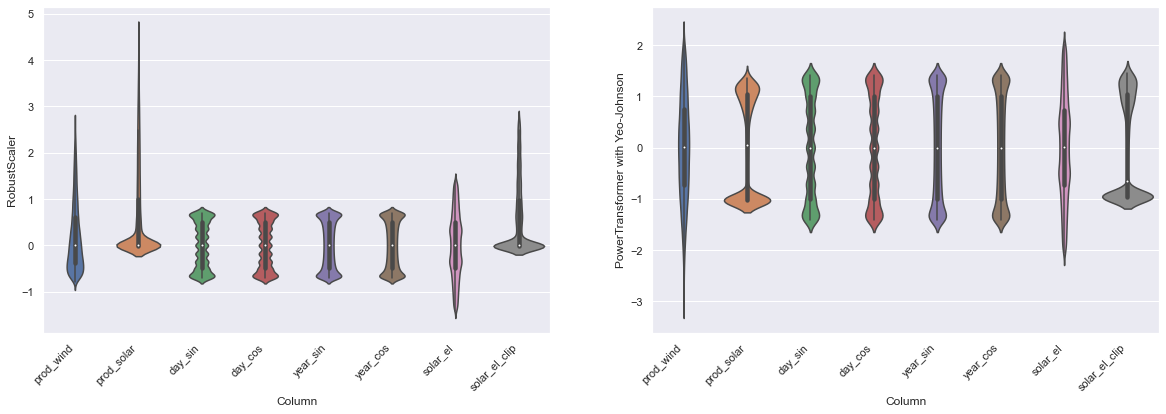

In [20]:
from sklearn.preprocessing import RobustScaler, PowerTransformer

sns.set()  # Setting seaborn as default style even if use only matplotlib
# Scale with the RobustScaler
df_rob = pd.DataFrame(RobustScaler().fit_transform(df),
                      columns=df.columns, index=df.index)
# Transform to Gaussian Distribution with Yeo-Johnson
df_tyj = pd.DataFrame(PowerTransformer(method="yeo-johnson").fit_transform(df),
                      columns=df.columns, index=df.index)

# plot normalizations
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)
sns.violinplot(ax=axes[0], x='Column', y='RobustScaler',
               data=df_rob.melt(var_name='Column', value_name='RobustScaler'))
sns.violinplot(ax=axes[1], x='Column', y='PowerTransformer with Yeo-Johnson',
               data=df_tyj.melt(var_name='Column', value_name='PowerTransformer with Yeo-Johnson'))
axes[0].set_xticklabels(df.keys(), rotation=45, ha="right")
_ = axes[1].set_xticklabels(df.keys(), rotation=45, ha="right")


## Find correlations

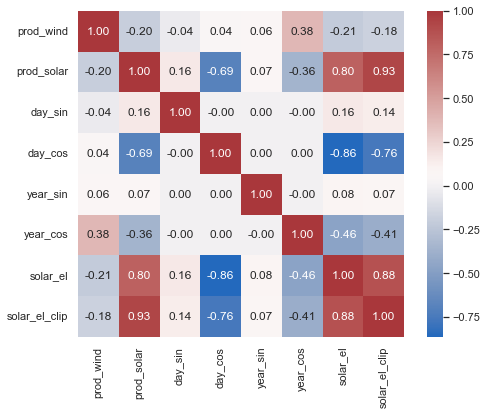

In [21]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(8, 6))
cmap = sns.color_palette("vlag", as_cmap=True)
_ = sns.heatmap(corr, cmap=cmap, annot=True, fmt=".2f", square=True)

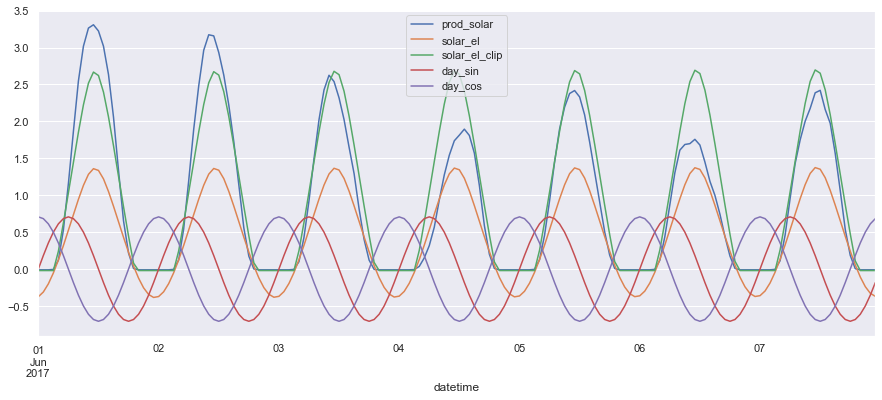

In [22]:
_ = df_rob.loc["2017-06-01":"2017-06-7"][["prod_solar", "solar_el", "solar_el_clip", "day_sin", "day_cos"]].plot(figsize=(15,6))

## Data Export

In [23]:
# export data
# df.to_pickle("../data/data_prepared.pkl")